In [1488]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta

data = pd.read_csv("data.csv")

In [1489]:
select_maturity_dates = [
    "3/1/2025", "9/1/2025", "3/1/2026", "9/1/2026",
    "3/1/2027", "9/1/2027", "3/1/2028", "9/1/2028",
    "3/1/2029", "9/1/2029", "3/1/2030"
]
filtered_df = data[data["Maturity Date"].isin(select_maturity_dates)]
filtered_df['Maturity Date'] = pd.to_datetime(filtered_df['Maturity Date'])
sorted_df = filtered_df.sort_values(by='Maturity Date')
select_data = sorted_df.reset_index(drop=True)
select_data["Coupon"] = select_data["Coupon"].str.rstrip('%').astype(float) / 100

select_data.to_csv("selected_data.csv", index=False)
days_to_last_coupon = 128

dirty_prices = []   
for index, bond in select_data.iterrows():
    bond_row = {
        "ISIN": bond["ISIN"],
        "Coupon": bond["Coupon"],
        "Maturity Date": bond["Maturity Date"],
    }
    
    for i in [6, 7, 8, 9, 10, 13, 14, 15, 16, 17]:
        price = bond[f'{i}-Jan']
        accrued_interest = (bond["Coupon"] * 100) * (days_to_last_coupon / 365)
        dirty_price = price + accrued_interest
        bond_row[f'{i}-Jan Dirty Price'] = dirty_price
    
    dirty_prices.append(bond_row)

dirty_price_data = pd.DataFrame(dirty_prices)

dirty_price_data.to_csv("dirty_prices_per_bond.csv", index=False)

print(dirty_price_data)

            ISIN  Coupon Maturity Date  6-Jan Dirty Price  7-Jan Dirty Price  \
0   CA135087K528  0.0125    2025-03-01         100.168356         100.168356   
1   CA135087K940  0.0050    2025-09-01          98.575342          98.585342   
2   CA135087L518  0.0025    2026-03-01          97.077671          97.067671   
3   CA135087L930  0.0100    2026-09-01          97.360685          97.340685   
4   CA135087M847  0.0125    2027-03-01          97.058356          97.028356   
5   CA135087N837  0.0275    2027-09-01         100.594384         100.524384   
6   CA135087P576  0.0350    2028-03-01         103.047397         103.047397   
7   CA135087Q491  0.0325    2028-09-01         102.239726         102.279726   
8   CA135087Q988  0.0400    2029-03-01         105.472740         105.412740   
9   CA135087R895  0.0350    2029-09-01         103.447397         103.367397   
10  CA135087S471  0.0275    2030-03-01          99.774384          99.544384   

    8-Jan Dirty Price  9-Jan Dirty Pric

/tmp/ipykernel_10993/106806693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Maturity Date'] = pd.to_datetime(filtered_df['Maturity Date'])


In [1490]:
from datetime import datetime
import pytz

ytm_data = []
# Get current Toronto time
toronto_tz = pytz.timezone("America/Toronto")
toronto_time = datetime.now(toronto_tz)
toronto_time = pd.Timestamp(toronto_time)

In [1491]:
dirty_price_data['Maturity Date'][0]

Timestamp('2025-03-01 00:00:00')

In [1492]:
toronto_time

Timestamp('2025-02-02 01:30:18.149375-0500', tz='America/Toronto')

In [1493]:
import pandas as pd

def month_difference(ts1: pd.Timestamp, ts2: pd.Timestamp) -> int:
    """
    Calculate the number of months between two pandas Timestamp objects.

    :param ts1: First pandas Timestamp.
    :param ts2: Second pandas Timestamp.
    :return: Difference in months as an integer.
    """
    return abs((ts2.year - ts1.year) * 12 + (ts2.month - ts1.month))

ts1 = toronto_time
ts2 = dirty_price_data['Maturity Date'][0]

print(month_difference(ts1, ts2))


1


In [1494]:
import pandas as pd
from scipy.optimize import newton

# Function to calculate the number of months between two timestamps
def month_difference(ts1: pd.Timestamp, ts2: pd.Timestamp) -> int:
    """Calculate the number of months between two pandas Timestamp objects."""
    return abs((ts2.year - ts1.year) * 12 + (ts2.month - ts1.month))
    
# Zero-coupon bond YTM  
def zero_coupon_ytm(price, face_value, time_to_maturity, coupon_rate):
    return ((face_value + coupon_rate * 100) / price) ** (1 / time_to_maturity) - 1

def bond_price_function(ytm, face_value, coupon, freq, time_to_maturity, dirty_price):
    coupon_payment = coupon * face_value / freq
    n_payments = int(time_to_maturity * freq)
    t = np.linspace(0.5, np.floor(time_to_maturity), n_payments)
    discount_factors = (1 + ytm) ** (-t)
    pv_coupons = coupon_payment * np.sum(discount_factors)
    pv_final = (face_value + coupon_payment) * (1 + ytm) ** (-time_to_maturity)

    return pv_coupons + pv_final - dirty_price

def calculate_ytm(face_value, coupon, freq, time_to_maturity, dirty_price):
    """Calculate yield to maturity using Newton-Raphson method."""
    if time_to_maturity < 0.5:
        return zero_coupon_ytm(dirty_price, face_value, time_to_maturity, coupon)
    try:
        print(time_to_maturity)
        initial_guess = coupon / face_value
        ytm = newton(bond_price_function, initial_guess, args=(face_value, coupon, freq, time_to_maturity, dirty_price))
        return ytm
    except RuntimeError:
        return np.nan

toronto_time = pd.Timestamp("2025-01-01")
ytm_results = []
dirty_price_data = pd.read_csv("dirty_prices_per_bond.csv")

for index, row in dirty_price_data.iterrows():
    current_date = toronto_time
    maturity_date = pd.Timestamp(row["Maturity Date"])
    coupon = row["Coupon"]
    freq = 2  # Semi-annual coupons
    
    row_ytm_data = []
    months_to_maturity = month_difference(current_date, maturity_date)
    time_to_maturity = months_to_maturity / 12

    for col_index, col_name in enumerate(row.index[3:]):
        dirty_price = row[col_name]
        ytm = calculate_ytm(100, coupon, freq, time_to_maturity, dirty_price)

        row_ytm_data.append(ytm)

    ytm_results.append(row_ytm_data)

ytm_df = pd.DataFrame(ytm_results)



0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.1666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
1.6666666666666667
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.1666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
2.6666666666666665
3.1666666666666665
3.1666666666666665
3.1666666666

In [1495]:
ytm_df.to_csv("ytm_results.csv", index=False)

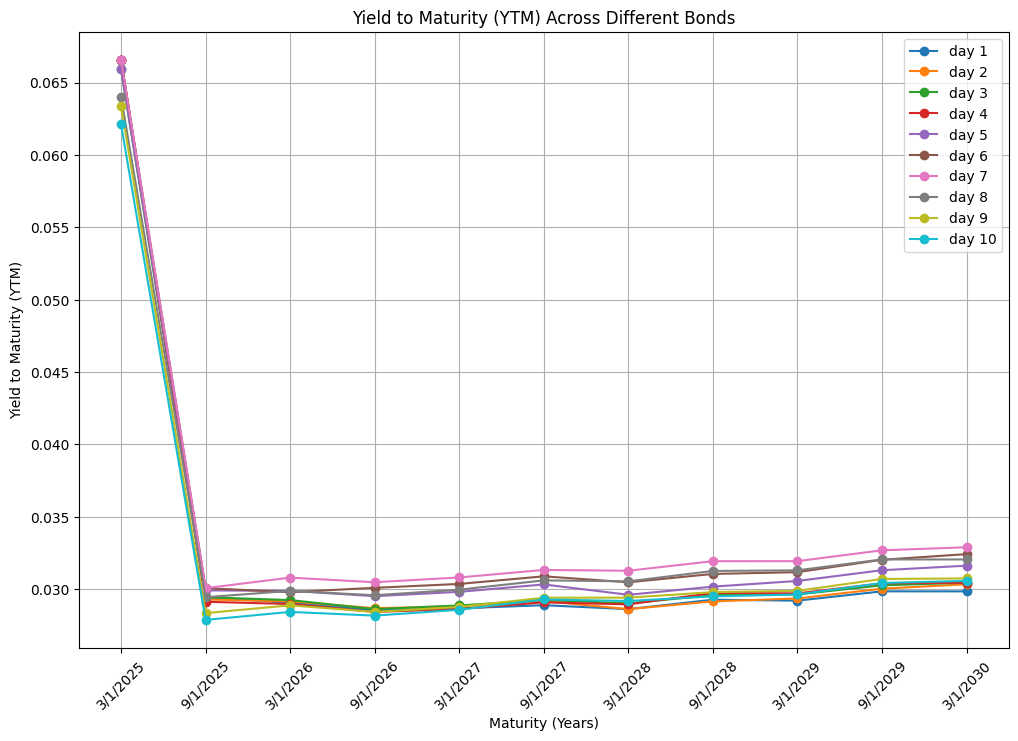

In [1496]:
import matplotlib.pyplot as plt
import numpy as np

# Convert YTM results into a DataFrame
ytm_df = pd.DataFrame(ytm_results, columns=dirty_price_data.columns[3:]).transpose()
x_dates = pd.date_range(start="2025-03-01", end="2029-09-01", freq="6MS").strftime('%m/%d/%Y')
ytm_df.index = x_dates[:len(ytm_df)]    
# Create a figure and plot each bond's YTM over time
plt.figure(figsize=(12, 8))
for row_index in range(ytm_df.shape[0]):
    plt.plot(select_maturity_dates, ytm_df.iloc[row_index], marker='o', linestyle='-', label=f'day {row_index+1}')

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (YTM)")
plt.title("Yield to Maturity (YTM) Across Different Bonds")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)

plt.show()


In [1497]:
dirty_price_data = pd.read_csv("dirty_prices_per_bond.csv")
coupon_rates = dirty_price_data["Coupon"]
toronto_time = pd.Timestamp("2025-01-01")
maturity_day_fraction = []

for index, row_index in enumerate(coupon_rates):
    maturity_date = pd.Timestamp(dirty_price_data["Maturity Date"][index])
    months_to_maturity = month_difference(toronto_time, maturity_date)
    time_to_maturity = months_to_maturity / 12 * 2 + 1
    maturity_day_fraction.append(int(time_to_maturity))
print(maturity_day_fraction)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


**Question 2.**

In [1498]:
import numpy as np
from scipy.optimize import fsolve

def bootstrap_yield_curve(bonds):
    """
    Bootstraps the spot yield curve given bond prices, coupon rates, and maturities.
    
    Args:
        bonds: List of tuples (price, coupon_rate, maturity) [(P1, C1, T1), (P2, C2, T2), ...]
    
    Returns:
        NumPy array of spot rates for each bond maturity.
    """
    bonds = sorted(bonds, key=lambda x: x[2])  # Sort bonds by maturity
    spot_rates = np.zeros(len(bonds))

    for i, (price, coupon_rate, maturity) in enumerate(bonds):
        cash_flows = np.array([coupon_rate] * (maturity - 1) + [100 + (coupon_rate /2 * 100)])
        time_periods = np.arange(1, maturity + 1)
        def bond_price_eq(spot_rate):
            """Bootstrap equation for spot rate calculation."""
            discount_factors = (1 + spot_rate) ** time_periods
            if i > 0:
                # Use previous spot rates to discount earlier cash flows
                discounted_cf = np.sum(cash_flows[:-1] / (1 + spot_rates[:i])**time_periods[:i])
            else:
                discounted_cf = 0
            return np.sum(cash_flows / discount_factors) - price + discounted_cf

        # Solve for the new spot rate using numerical root-finding
        spot_rate_guess = 0.05  # Initial guess (5%)
        spot_rates[i] = fsolve(bond_price_eq, spot_rate_guess)[0]

    return spot_rates


In [1499]:
spot_rates = []

for index, col_index in enumerate(dirty_price_data.columns[3:]):
    dirty_price_data[col_index] = dirty_price_data[col_index] 
    bond_prices = dirty_price_data[col_index].values
    bonds = list(zip(bond_prices, coupon_rates, maturity_day_fraction))
    spot_rate = bootstrap_yield_curve(bonds)
    spot_rates.append(spot_rate)

spot_rates_df = pd.DataFrame(spot_rates)
spot_rates_df = spot_rates_df.transpose()
spot_rates_df.to_csv("spot_rates.csv", index=False)



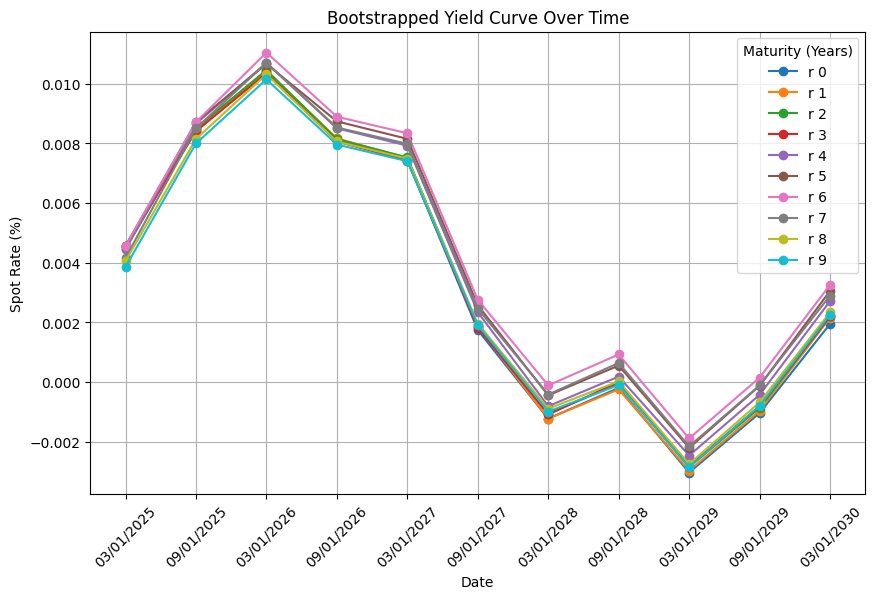

In [1500]:
import matplotlib.pyplot as plt
import pandas as pd


x_dates = pd.date_range(start="2025-03-01", end="2030-03-01", freq="6MS").strftime('%m/%d/%Y')

spot_rates_df.index = x_dates[:len(spot_rates_df)]  # Adjust index to match the dates

# Plot
plt.figure(figsize=(10, 6))

for col in spot_rates_df.columns:
    plt.plot(spot_rates_df.index, spot_rates_df[col], marker='o', linestyle='-', label=f"r {col}")
    
plt.xlabel("Date")
plt.ylabel("Spot Rate (%)")
plt.title("Bootstrapped Yield Curve Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title="Maturity (Years)")
plt.grid(True)

plt.show()


In [1501]:
pd.Timestamp.today()

Timestamp('2025-02-02 01:30:18.948844')